### calculates M1, Z1 and SAM (40S - 65S zonal mean) from the ERA5 reanalysis data 

In [1]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr

### plotting 
from matplotlib import pyplot as plt


In [2]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 


### path to the raw data reanalysis 

In [3]:
dpath_raw = pathlib.Path('/media/nicolasf/END19101/data/REANALYSIS/downloads/MSLP/')

In [4]:
lfiles_era_raw = list(dpath_raw.glob("*.nc"))

In [5]:
lfiles_era_raw.sort()

In [6]:
len(lfiles_era_raw)

502

In [7]:
dset = xr.open_mfdataset(lfiles_era_raw, concat_dim='time', combine='nested', parallel=True)

In [8]:
dset

,Array,Chunk
Bytes,2.08 GB,4.15 MB
Shape,"(502, 721, 1440)","(1, 721, 1440)"
Count,1506 Tasks,502 Chunks
Type,float32,numpy.ndarray


### calculates the SAM

This version of the SAM is calculated using SLP from the 20CRV2c. (SAM) is defined as the difference of zonal mean sea level pressure between 40°S and 65°S. The zonal means at 40°S and 65°S are each calculated. Each month's zonal mean is standardized by the mean/standard deviation determined for the climatological time period (1981-2010). Then, the 65°S value is subtracted from the 40°S value for each month. 

In [9]:
s40 = dset.sel(latitude=-40).mean('longitude')

In [10]:
s65 = dset.sel(latitude=-65).mean('longitude')

In [11]:
s65 = s65['msl'].to_dataframe().drop('latitude', axis=1)

In [12]:
s40 = s40['msl'].to_dataframe().drop('latitude', axis=1)

In [13]:
clims40 = s40.loc['1981':'2010',:]

In [14]:
clims65 = s65.loc['1981':'2010',:]

In [15]:
def demean(x): 
    z = (x - x.loc['1981':'2010',:].mean()) / x.loc['1981':'2010',:].std() 
    return z

In [16]:
s65 = s65.groupby(s65.index.month).apply(demean)

In [17]:
s40 = s40.groupby(s40.index.month).apply(demean)

In [18]:
SAM = s40 - s65

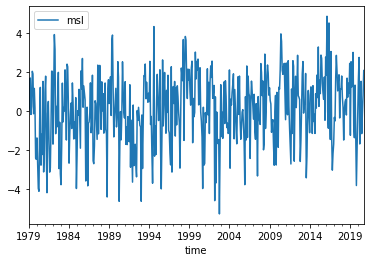

In [19]:
SAM.plot()

### get the SAM index from NOAA for comparison 

In [20]:
url = "https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/aao/monthly.aao.index.b79.current.ascii.table"

In [21]:
SAM_noaa = pd.read_table(url, sep=r"\s+") 

In [22]:
SAM_noaa = SAM_noaa.stack()

In [23]:
SAM_noaa.index = pd.date_range(start='1979-01-01', freq='MS', periods=len(SAM_noaa))

In [24]:
SAM_noaa = SAM_noaa.to_frame(name='SAM')

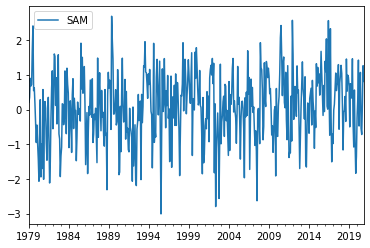

In [25]:
SAM_noaa.plot()

In [26]:
pd.concat([SAM, SAM_noaa], axis=1).corr()

,msl,SAM
msl,1.00000,0.90238
SAM,0.90238,1.00000


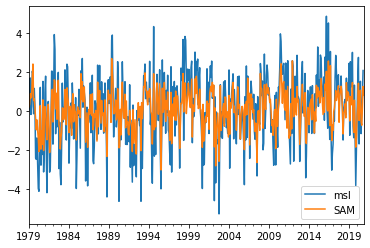

In [27]:
pd.concat([SAM, SAM_noaa], axis=1).plot()

In [29]:
SAM.columns = ['SAM_monthly']

### calculates seasonal values 

In [33]:
SAM.loc[:,'SAM_seasonal'] = SAM.loc[:,'SAM_monthly'].rolling(window=3, min_periods=3).mean()

### saves the SAM index to disk

In [35]:
opath = pathlib.Path("/media/nicolasf/END19101/data/climate_indices/observed/SAM_ERA5") 

In [36]:
if not opath.exists():
    opath.mkdir(parents=True)

In [37]:
SAM.to_csv(opath.joinpath("SAM_ERA5.csv")) 

### Now calculates the M1 and Z1 indices 

**M1:** 

→ Hobart: 42.8821° S, 147.3272° E 
→ Chatham Island: 44.0058° S, 176.5401° W 

**Z1:** 

→ Auckland: 36.8483° S, 174.7625° E 
→ Christchurch: 43.5320° S, 172.6397° E 

In [49]:
M1 = dset.sel(latitude=-42.8821, longitude=147.3272, method='nearest') - dset.sel(latitude=-44.0058, longitude=176.5401, method='nearest')

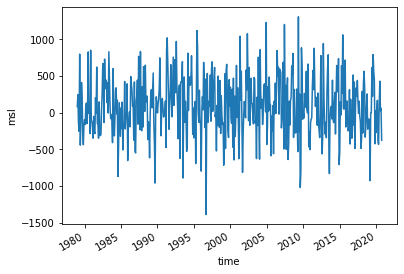

In [50]:
M1['msl'].plot()

In [51]:
M1 = M1['msl'].to_dataframe()

In [52]:
M1.columns = ['M1_monthly']

### Z1

In [53]:
Z1 = dset.sel(latitude=-36.8483, longitude=174.7625, method='nearest') - dset.sel(latitude=-43.5320, longitude=172.6397, method='nearest')

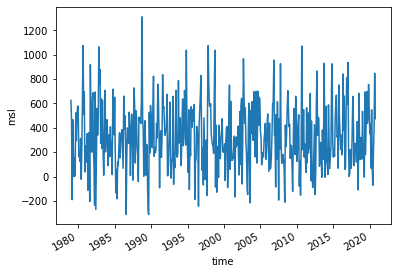

In [54]:
Z1['msl'].plot()

In [55]:
Z1 = Z1['msl'].to_dataframe()

In [56]:
Z1.columns = ['Z1_monthly']

### removes the climatology 

In [57]:
M1 = M1.groupby(M1.index.month).apply(demean)

In [58]:
Z1 = Z1.groupby(Z1.index.month).apply(demean)

In [59]:
M1

,M1_monthly
time,
1979-01-01,0.614772
1979-02-01,0.782328
1979-03-01,-0.704611
1979-04-01,-1.006261
1979-05-01,0.940957
...,...
2020-06-01,-0.688697
2020-07-01,0.646712
2020-08-01,-0.077022


In [60]:
Z1

,Z1_monthly
time,
1979-01-01,1.098355
1979-02-01,1.559543
1979-03-01,-1.765915
1979-04-01,1.102250
1979-05-01,-0.128685
...,...
2020-06-01,-1.506259
2020-07-01,0.284969
2020-08-01,0.342709


### calculates seasonal values 

In [62]:
M1.loc[:,'M1_seasonal'] = M1.loc[:,'M1_monthly'].rolling(window=3, min_periods=3).mean() 

In [63]:
M1.head()

,M1_monthly,M1_seasonal
time,,
1979-01-01,0.614772,NaN
1979-02-01,0.782328,NaN
1979-03-01,-0.704611,0.230830
1979-04-01,-1.006261,-0.309515
1979-05-01,0.940957,-0.256638


In [64]:
Z1.loc[:,'Z1_seasonal'] = Z1.loc[:,'Z1_monthly'].rolling(window=3, min_periods=3).mean() 

In [65]:
Z1.head()

,Z1_monthly,Z1_seasonal
time,,
1979-01-01,1.098355,NaN
1979-02-01,1.559543,NaN
1979-03-01,-1.765915,0.297327
1979-04-01,1.102250,0.298626
1979-05-01,-0.128685,-0.264117


### compare with the indices calculated by Brett from the station data 

In [66]:
Indices_Brett = pd.read_csv("/home/nicolasf/research/Smart_Ideas/code/rainml/data/preprocessed/monthly.csv", index_col=0, parse_dates=True) 

In [67]:
pd.concat([Indices_Brett.loc[:,['m1_0']], M1], axis=1).corr()

,m1_0,M1_monthly,M1_seasonal
m1_0,1.000000,0.924316,0.572257
M1_monthly,0.924316,1.000000,0.581990
M1_seasonal,0.572257,0.581990,1.000000


In [68]:
pd.concat([Indices_Brett.loc[:,['z1_0']], Z1], axis=1).corr()

,z1_0,Z1_monthly,Z1_seasonal
z1_0,1.000000,0.967586,0.559804
Z1_monthly,0.967586,1.000000,0.586188
Z1_seasonal,0.559804,0.586188,1.000000


In [72]:
opath = pathlib.Path("/media/nicolasf/END19101/data/climate_indices/observed/M1_ERA5") 

In [73]:
if not opath.exists():
    opath.mkdir(parents=True)

In [74]:
M1.to_csv(opath.joinpath("M1_ERA5.csv")) 

In [75]:
opath = pathlib.Path("/media/nicolasf/END19101/data/climate_indices/observed/Z1_ERA5") 

In [76]:
if not opath.exists():
    opath.mkdir(parents=True)

In [77]:
Z1.to_csv(opath.joinpath("Z1_ERA5.csv")) 